# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://colab.research.google.com/drive/1WYmsNwmSoJpUQJuAiqUkBWd9vP7O7hiX?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt


## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-3-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
#Max value of each coloumn

# "age", "yredu", "capgain", "caploss", "workhr"
#Max/Min/Ave Age
print("AGE MAX:", np.max(df["age"]), "AGE MIN:", np.min(df["age"]), "AGE AVE:", np.average(df["age"]))

#Max/Min/Ave Year Education
print("YEAR EDU MAX:", np.max(df["yredu"]), "YEAR EDU MIN:", np.min(df["yredu"]), "YEAR EDU AVE:", np.average(df["yredu"]))

#Max/Min/Ave CapGain
print("CAPGAIN MAX:", np.max(df["capgain"]), "CAPGAIN MIN:", np.min(df["capgain"]), "CAPGAIN AVE:", np.average(df["capgain"]))

#Max/Min/Ave CapLoss
print("CAPLOSS MAX:", np.max(df["caploss"]), "CAPLOSS MIN:", np.min(df["caploss"]), "CAPLOSS AVE:", np.average(df["caploss"]))

#Max/Min/Ave Work Hours
print("WORK HOUR MAX:", np.max(df["workhr"]), "WORK HOUR MIN:", np.min(df["workhr"]), "WORK HOUR AVE:", np.average(df["workhr"]))

AGE MAX: 90 AGE MIN: 17 AGE AVE: 38.58164675532078
YEAR EDU MAX: 16 YEAR EDU MIN: 1 YEAR EDU AVE: 10.0806793403151
CAPGAIN MAX: 99999 CAPGAIN MIN: 0 CAPGAIN AVE: 1077.6488437087312
CAPLOSS MAX: 4356 CAPLOSS MIN: 0 CAPLOSS AVE: 87.303829734959
WORK HOUR MAX: 99 WORK HOUR MIN: 1 WORK HOUR AVE: 40.437455852092995


In [ ]:
#Modification Normalization

#Age
df["age"] = (df["age"] - df["age"].min())/(df["age"].max() - df["age"].min())
print(df["age"])

#Year Education
df["yredu"] = (df["yredu"] - df["yredu"].min())/(df["yredu"].max() - df["yredu"].min())
print(df["yredu"])

#CapGain
df["capgain"] = (df["capgain"] - df["capgain"].min())/(df["capgain"].max() - df["capgain"].min())
print(df["capgain"])

#CapLoss
df["caploss"] = (df["caploss"] - df["caploss"].min())/(df["caploss"].max() - df["caploss"].min())
print(df["caploss"])

#Work Hours
df["workhr"] = (df["workhr"] - df["workhr"].min())/(df["workhr"].max() - df["workhr"].min())
print(df["workhr"])

0        0.301370
1        0.452055
2        0.287671
3        0.493151
4        0.150685
           ...   
32556    0.136986
32557    0.315068
32558    0.561644
32559    0.068493
32560    0.479452
Name: age, Length: 32561, dtype: float64
0        0.800000
1        0.800000
2        0.533333
3        0.400000
4        0.800000
           ...   
32556    0.733333
32557    0.533333
32558    0.533333
32559    0.533333
32560    0.533333
Name: yredu, Length: 32561, dtype: float64
0        0.021740
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
32556    0.000000
32557    0.000000
32558    0.000000
32559    0.000000
32560    0.150242
Name: capgain, Length: 32561, dtype: float64
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
32556    0.0
32557    0.0
32558    0.0
32559    0.0
32560    0.0
Name: caploss, Length: 32561, dtype: float64
0        0.397959
1        0.122449
2        0.397959
3        0.397959
4        0.397959

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

21790

In [ ]:
#Gender Percentage

count_male = sum(df["sex"] == " Male")

count_female = sum(df["sex"] == " Female")

count_total = df["sex"].count()

percent_male = (100*(count_male)/(count_total))
percent_female = (100*(count_female)/(count_total))

print("Percentage Male:", percent_male, "and Percentage Female:", percent_female )

Percentage Male: 66.92054912318417 and Percentage Female: 33.07945087681582


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
#Finding Percent Removed
total_before = len(df)

total_after = len(df_with_missing)

print("The amount of records containing missing feautres", (total_before - total_after))

print("Percent removed:", (100*(total_after/total_before)))

The amount of records containing missing feautres 30718
Percent removed: 5.660145572924664


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
#Using Set
set(df_not_missing["work"])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
#Getting Num Cols
len(data.columns)

#57 columns

57

**There are 57 coloumns. The get_dummies function **

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.

    #ind = np.argmax(onehot)
    #values = cat_values[features]
    return cat_values[feature][np.argmax(onehot)]

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

train_ind = int(datanp.shape[0] * 0.7)
val_ind = int(datanp.shape[0]* 0.85)

train_dataset = datanp[:train_ind]
val_dataset = datanp[train_ind: val_ind]
test_dataset = datanp[val_ind:]


print('Amount Training Set Data:', str(train_dataset.shape[0]))
print('Amount Validation Set Data:', str(val_dataset.shape[0]))
print('Amount Testing Set Data:', str(test_dataset.shape[0]))

#Amount Training Set Data: 21502
#Amount Validation Set Data: 4608
#Amount Testing Set Data: 4608

Amount Training Set Data: 21502
Amount Validation Set Data: 4608
Amount Testing Set Data: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 43), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(43,29),
            nn.Linear(29, 15)
        )
        self.decoder = nn.Sequential(
            nn.Linear(15, 29), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(29, 43),
            nn.Linear(43,57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

**Since our data has been normalized to be withtin the range of 0 to 1 the sigmoid function matches the format of our input as the sigmoid fuction also produces an output in the range of 0 and 1, enabling the decoder to match the inputs of the encoder**

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def get_val_loss(model, data_loader, criterion):
  total_val_loss = 0
  i = 0
  for data in data_loader:
    datam = zero_out_random_feature(data.clone())
    recon = model(datam)
    loss = criterion(recon, data)
    total_val_loss += loss.item()
    i += 1
  return total_val_loss/(i + 1)

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_accuracy = np.zeros(num_epochs)
    val_accuracy = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):
      total_loss = 0
      i = 0
      for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            i +=1
      train_accuracy[epoch] = get_accuracy(model, train_loader)
      val_accuracy[epoch] = get_accuracy(model,valid_loader)
      train_loss[epoch] = float(total_loss)/(i+1)
      val_loss[epoch] = get_val_loss(model, valid_loader, criterion)

      print("epoch:", epoch, end=" ")
      print("train accuracy:", train_accuracy[epoch], end=" ")
      print("val accuracy:", val_accuracy[epoch])

    epochs = np.arange(1, num_epochs + 1)





    return train_accuracy, val_accuracy, train_loss, val_loss, epochs

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

epoch: 0 train accuracy: 0.43608346510402135 val accuracy: 0.4354383680555556
epoch: 1 train accuracy: 0.4585309893653304 val accuracy: 0.4581163194444444
epoch: 2 train accuracy: 0.4566861997333581 val accuracy: 0.45533130787037035
epoch: 3 train accuracy: 0.5249821722010356 val accuracy: 0.5236906828703703
epoch: 4 train accuracy: 0.5373841193067311 val accuracy: 0.5355541087962963
epoch: 5 train accuracy: 0.5512122903295817 val accuracy: 0.5482855902777778
epoch: 6 train accuracy: 0.5603819799708554 val accuracy: 0.5572193287037037
epoch: 7 train accuracy: 0.5652962515114873 val accuracy: 0.5620659722222222
epoch: 8 train accuracy: 0.5672883142653397 val accuracy: 0.5680338541666666
epoch: 9 train accuracy: 0.5665519486559389 val accuracy: 0.5682146990740741
epoch: 10 train accuracy: 0.568629274796143 val accuracy: 0.5712167245370371
epoch: 11 train accuracy: 0.570714352153288 val accuracy: 0.5735677083333334
epoch: 12 train accuracy: 0.5722103370229126 val accuracy: 0.5762442129629

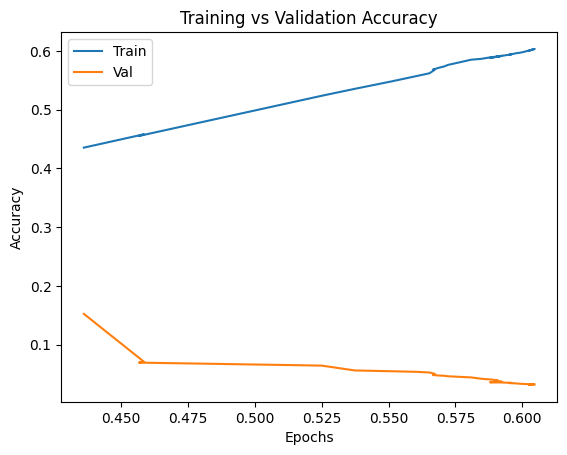

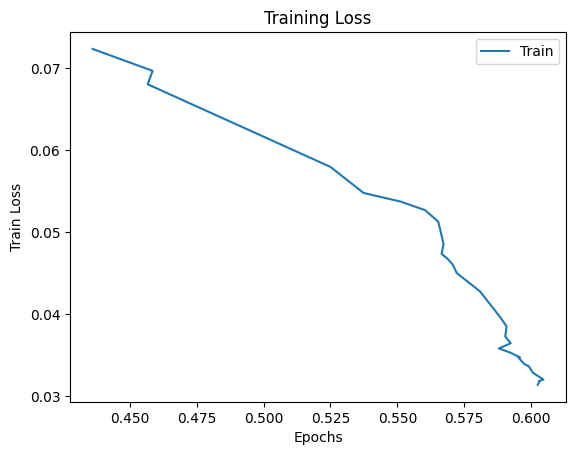

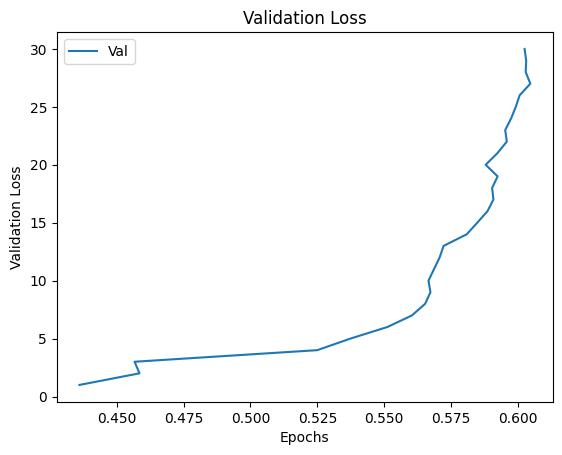

In [ ]:
#Initalize Parameters
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = 1)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size,  num_workers = 1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, num_workers = 1)

autoencoder = AutoEncoder()

num_epochs, train_accuracy, val_accuracy, train_loss, val_loss = train(autoencoder, train_loader, val_loader, num_epochs=30, learning_rate=0.0001)






### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

epoch: 0 train accuracy: 0.5603897311877964 val accuracy: 0.5591724537037037
epoch: 1 train accuracy: 0.5768688184044896 val accuracy: 0.5785228587962963
epoch: 2 train accuracy: 0.5818838557653552 val accuracy: 0.5887225115740741
epoch: 3 train accuracy: 0.5912163209623911 val accuracy: 0.5964988425925926
epoch: 4 train accuracy: 0.5864260688928161 val accuracy: 0.5837311921296297
epoch: 5 train accuracy: 0.6026028586488079 val accuracy: 0.6019965277777778
epoch: 6 train accuracy: 0.6009596006573033 val accuracy: 0.5994646990740741
epoch: 7 train accuracy: 0.6169968685083558 val accuracy: 0.6154152199074074
epoch: 8 train accuracy: 0.6101913000341054 val accuracy: 0.6103515625
epoch: 9 train accuracy: 0.614431215700865 val accuracy: 0.6130280671296297
epoch: 10 train accuracy: 0.6097804855362292 val accuracy: 0.6092664930555556
epoch: 11 train accuracy: 0.6126871918891266 val accuracy: 0.6111111111111112
epoch: 12 train accuracy: 0.6135398257526432 val accuracy: 0.6091218171296297
epo

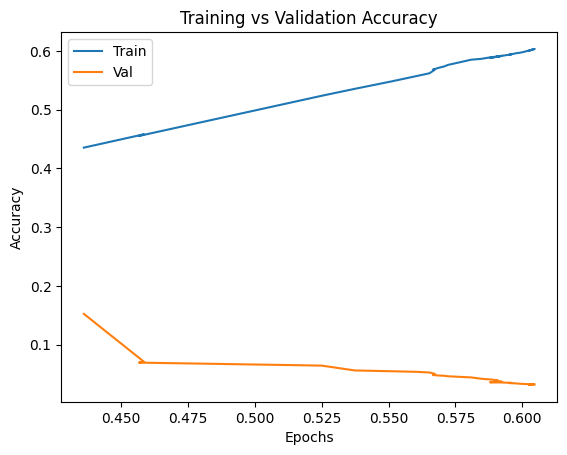

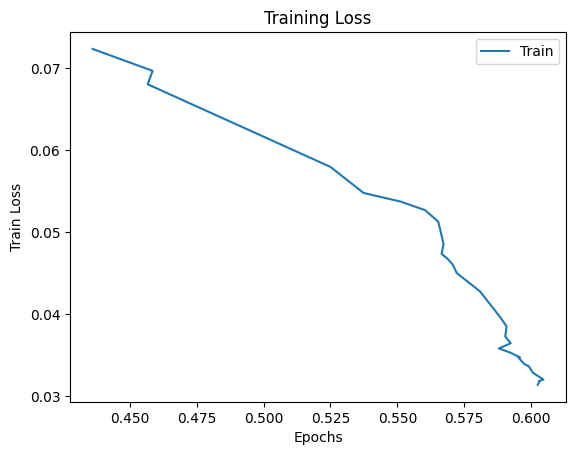

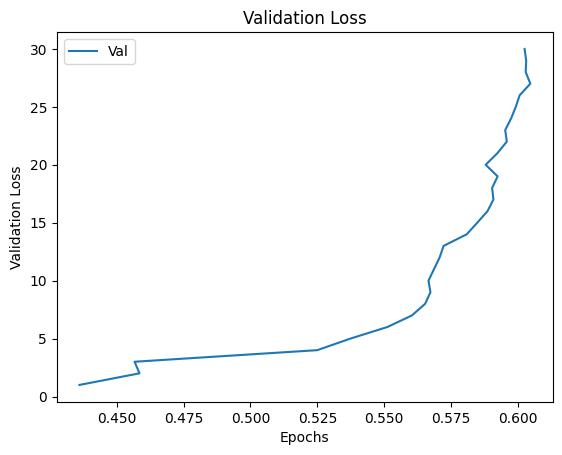

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=80, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=80, shuffle=True)
model = AutoEncoder()
train(model, train_loader, valid_loader, num_epochs=100, learning_rate = 0.001)
 #Plotting
plt.title("Training vs Validation Accuracy")
plt.plot(num_epochs, train_accuracy, label="Train")
plt.plot(num_epochs, val_accuracy, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Training Loss")
plt.plot(num_epochs, train_loss, label="Train")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.legend(loc='best')
plt.show()

plt.title("Validation Loss")
plt.plot(num_epochs, val_loss, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend(loc='best')
plt.show()

epoch: 0 train accuracy: 0.5972622701764176 val accuracy: 0.5972945601851852
epoch: 1 train accuracy: 0.5904489504852262 val accuracy: 0.5884693287037037
epoch: 2 train accuracy: 0.5970529873190091 val accuracy: 0.5934968171296297
epoch: 3 train accuracy: 0.5915186184230924 val accuracy: 0.5890118634259259
epoch: 4 train accuracy: 0.592371252286609 val accuracy: 0.5900245949074074
epoch: 5 train accuracy: 0.5919449353548507 val accuracy: 0.5880714699074074
epoch: 6 train accuracy: 0.5923557498527269 val accuracy: 0.5863353587962963
epoch: 7 train accuracy: 0.5877515269897374 val accuracy: 0.5841652199074074
epoch: 8 train accuracy: 0.6078736861687285 val accuracy: 0.6081814236111112
epoch: 9 train accuracy: 0.6098735001395219 val accuracy: 0.6080729166666666
epoch: 10 train accuracy: 0.615865190834961 val accuracy: 0.6123408564814815
epoch: 11 train accuracy: 0.6169581124236505 val accuracy: 0.6131727430555556
epoch: 12 train accuracy: 0.6163302638514246 val accuracy: 0.611328125
epoch

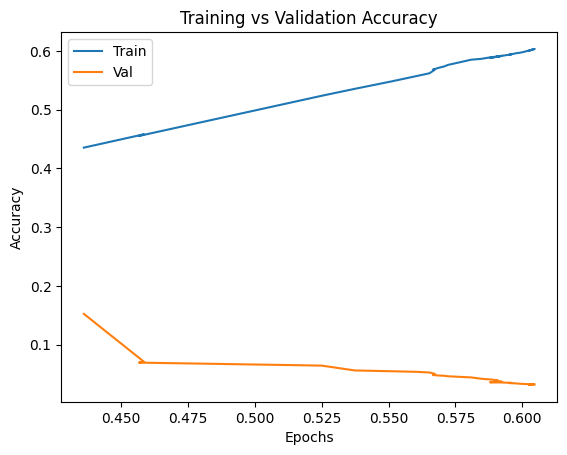

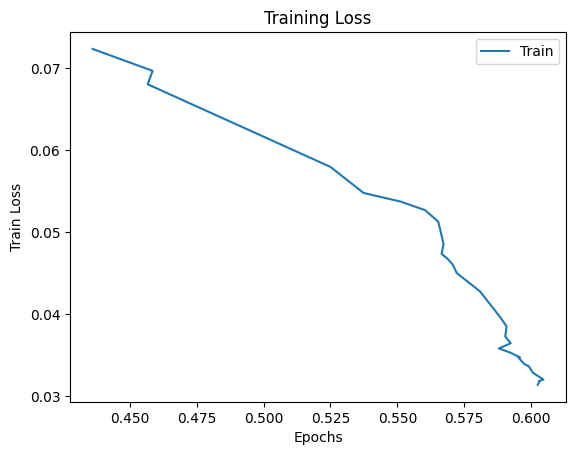

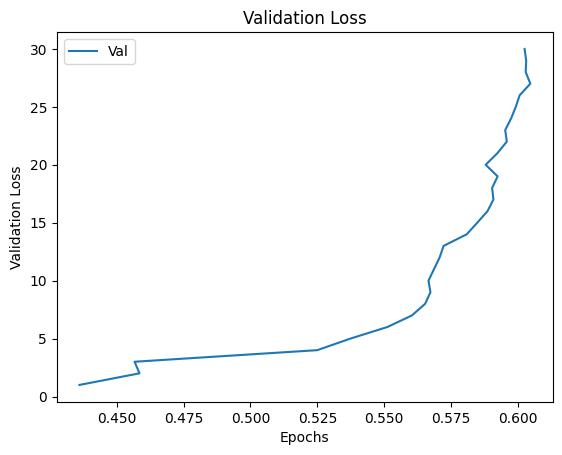

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=True)
model = AutoEncoder()
train(model, train_loader, valid_loader, num_epochs=500, learning_rate = 0.005)
 #Plotting
plt.title("Training vs Validation Accuracy")
plt.plot(num_epochs, train_accuracy, label="Train")
plt.plot(num_epochs, val_accuracy, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Training Loss")
plt.plot(num_epochs, train_loss, label="Train")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.legend(loc='best')
plt.show()

plt.title("Validation Loss")
plt.plot(num_epochs, val_loss, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend(loc='best')
plt.show()

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?